# 1 - Introdução 

Neste notebook, iremos desenvolver uma aplicação que classifica a imagem de um urso dentre três categorias: urso pardo, urso preto e ursinho de pelúcia. Iremos iniciar pela coleta dos dados, prosseguindo para o treinamento, análise dos resultados e, por fim, desenvolveremos uma simples aplicação online. Vamos lá.    

Antes, como em qualquer notebook, iremos fazer as configurações necessárias.

In [1]:
import fastbook
fastbook.setup_book()

/home/lucaszampar/anaconda3/envs/FASTAI/lib/python3.7/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


Além disso, para este notebook, precisaremos importar os seguintes módulos: 

In [2]:
from fastbook import *
from fastai.vision.widgets import *

# 2 - Coleta dos dados 

Como dito anteriormente, a fim de treinar qualquer modelo de machine learning, precisamos de dados. Essa é uma propriedade intrínseca à própria natureza do machine learning. No entanto, onde conseguir dados? 

Bem, é possível obtê-los através de datasets públicos ou privados. No notebook anterior, por exemplo, obtivemos as imagens de cães e de gatos a partir do dataset Oxford-IIIT Pet. Porém, podemos encontrar também diversas imagens online, através dos motores de busca como Google e Bing. Assim, com uma breve pesquisa, é possível montar o nosso dataset a fim de treinar nosso modelo.

## 2.1 - Bing Image Search API

Nesse contexto, iremos obter as imagens dos ursos que precisamos por meio da API do Bing Image Search que faz parte do Azure Cognitive Services. Para tanto, é necessário abrir uma conta gratuita no Azure, iniciar um grupo de recursos e inserir o serviço de busca do Bing neste. Dessa forma, uma chave de API será disponibilizada para você, a qual pode ser inserida no notebook através do código abaixo. 

In [6]:
chave_api = os.environ.get('AZURE_SEARCH_KEY', 'd39fd2ff-f73b-4cd4-b751-dac1919da668')

## 2.2 - Buscas com a API

Pronto, com isso já é possível realizar nossa primeira busca utilizando a função do fastai <code>search_images_bing</code>. Caso tenha dúvida de onde a função é proveniente, apenas digite o nome da função e execute a célula. 

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

A fim de testarmos a API, inicialmente buscaremos pelo termo grizzly bear (urso pardo).

In [7]:
resultados = search_images_bing(chave_api, 'grizzly bear')
url_imagens = resultados.attrgot('contentUrl')
len(url_imagens)

HTTPError: 401 Client Error: PermissionDenied for url: https://api.bing.microsoft.com/v7.0/images/search?q=grizzly+bear&count=150&min_height=128&min_width=128

A função nos retorna um objeto do tipo <code>fastcore.foundation.L</code>, o qual representa uma lista no fastai. Tal classe possui o método attrgot por meio do qual é possível extrair itens com base em um atributo. Utilizaremos então o atributo contentUrl do Azure com o intuito de obter as URLs das imagens encontradas na busca. Podemos ver que essa função retorna 150 resultados. 

## 2.3 - Download a partir dos resultados 

Como teste, iremos realizar o download da primeira imagem por meio da função <code>download_url</code>.

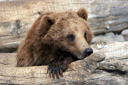

In [6]:
destino = 'imagens/grizzly.jpg'
download_url(url_imagens[0], destino)

imagem = Image.open(destino)
imagem.to_thumb(128,128)

A função criou a pasta imagens no diretório atual do notebook, realizando o download da imagem nesta. Além disso, é possível visualizar a imagem baixada. A partir destes exemplos, podemos então criar nosso dataset para os três tipos de ursos realizando consultas de imagens; em seguida, o respectivo download. 

## 2.4 - Criando o dataset a partir da busca e do download

Antes, só precisamos informar os tipos que desejamos buscar: grizzly (urso pardo), black (urso preto) e teddy (ursinho de pelúcia). Além disso, precisamos especificar o caminho que conterá as pastas com as imagens, no caso, a pasta ursos.

In [8]:
tipos_urso = 'grizzly','black','teddy'
path = Path('ursos')

A partir disso, podemos executar o seguinte código para, automaticamente, criar as pastas dos tipos de ursos, realizar as buscas e os downloads nas respectivas pastas. 

In [8]:
#se a pasta ursos não exitir
if not path.exists():
    #crie a pasta
    path.mkdir()
    #para cada urso nos tipos de ursos
    for urso in tipos_urso:
        #especifique a pasta do tipo de urso
        destino = (path/urso)
        #crie a pasta, caso não exista
        destino.mkdir(exist_ok=True)
        #resultados da busca
        resultados = search_images_bing(chave_api, f'{urso} bear')
        #baixe as imagens a partir da url na respectiva pasta
        download_images(destino, urls=resultados.attrgot('contentUrl'))

Pronto, realizamos a busca e o download das imagens que precisamos para treinar nosso modelo. Podemos acessar todas as imagens recursivamente pela função <code>get_image_files</code> passando como parâmetro o caminho da pasta ursos. 

In [9]:
imagens = get_image_files(path)
imagens

(#420) [Path('ursos/teddy/00000083.jpg'),Path('ursos/teddy/00000104.jpg'),Path('ursos/teddy/00000055.jpg'),Path('ursos/teddy/00000048.jpg'),Path('ursos/teddy/00000064.jpg'),Path('ursos/teddy/00000013.png'),Path('ursos/teddy/00000063.jpg'),Path('ursos/teddy/00000033.jpg'),Path('ursos/teddy/00000113.jpg'),Path('ursos/teddy/00000042.jpg')...]

## 2.5- Verficando arquivos corrompidos

Geralmente, quando baixamos arquivos pela internet, alguns podem estar corrompidos. Podemos verificar quais estão por meio da funçã <code>verify_images</code>.

In [10]:
imagens_corrompidas = verify_images(imagens)
imagens_corrompidas

(#0) []

A função também retorna um objeto do tipo <code>fastcore.foundation.L</code>, o qual possui o método map que aplica para cada item da lista a função passada como parâmetro. Assim, podemos desassociar as imagens corrompidas por meio do método unlink de Path.

In [11]:
imagens_corrompidas.map(Path.unlink)
imagens_corrompidas

(#0) []

Pronto, agora temos o dataset que precisamos para treinar nosso modelo!

# 3 - Formatação dos dados

Antes de iniciarmos o treinamento, precisamos preparar nossos dados em um formato apropriado para os métodos do fastai. Por exemplo, com base no nosso dataset atual, como especificaremos que estamos trabalhando com imagens? Como acessaremos essas imagens? Quais rótulos empregaremos? Como criaremos o dataset de validação? 

## 3.1- Data Block

Podemos satisfazer todos os requisitos citados por meio da API data block do fastai, a qual funciona como espécie de template dos nossos dados, informando o formato deles aos métodos do fatai. Vamos começar especificando os tipos das nossas variáveis dependentes e independentes. Bem, nossas variáveis independentes são imagens. Já as dependentes são as categorias que dependem das imagens. Podemos especificar, então, esses tipos por meio do código abaixo.

In [12]:
tipo_var_independente = ImageBlock
tipo_var_dependente = CategoryBlock

Agora, como acessaremos essas imagens? Simples, empreganda a função <code>get_image_files</code> apresentada anteriormente.

In [13]:
func_acesso = get_image_files

Além disso, precisaremos definir o rótulo das nossas categorias. Perceba que as imagens estão contidas nas pastas com as respectivas categorias de ursos: grizzly bear, black bear e teddy bear. Então, poderíamos empregar o nome dessas pastas, o que pode ser feito por meio da função <code>parent_label</code>. Vale lembrar que geralmente empregamos y para nos refereir à variável dependente, neste caso, às categorias.

In [14]:
y = parent_label

Por fim, precisamos apenas definir como obter o dataset de validação. Para tanto, empregaremos a mesma lógica do notebook passado, reservar 20% dos dados para validação, escolhendo sempre as mesmas imagens, o que pode ser feito pelo seguinte código.

In [15]:
divisor_dataset = RandomSplitter(valid_pct=0.2, seed=42)

A partir disso, podemos definir nosso bloco de dados. 

In [16]:
ursos = DataBlock(
            blocks = (tipo_var_independente, tipo_var_dependente), 
            get_items = func_acesso, 
            splitter = divisor_dataset,
            get_y = y, 
            item_tfms = Resize(128)
        )

## 3.2- Redimensionamento das imagens

É importante saber que não apresentamos uma imagem de cada vez para nosso modelo, mas várias no que é chamado de mini-batch. Para agruparmos todas as imagens em um grande array (comumente chamado de tensor) que será apresentado ao nosso modelo, precisamos que todas as imagens tenham o mesmo tamanho. Por isso, empregamos Resize(128).

Agora que temos a template dos nossos dados, precisamos informar onde os dados se encontram a fim de carregá-los.

In [17]:
dls = ursos.dataloaders(path)

<code>dataloaders</code> é uma classe do fastai que provê <code>dataloader</code>s de treino e validação. Por sua vez, <code>dataloader</code> é uma classe responsável por prover batches de alguns itens por vez para a GPU. Podemos observar alguns itens do batch de validação por meio do seguinte código. 

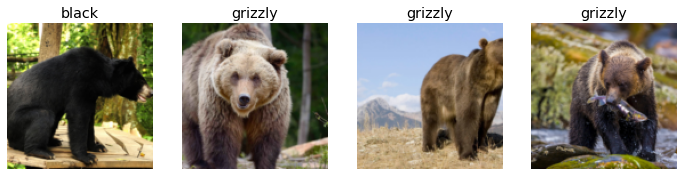

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

É possível notar que por padrão o método Resize realiza o crop da imagem, isto é, seleciona a região da imagem que caiba em um quadrado com as dimensões especificadas. Podemos alterar tal método para, por exemplo, esmagar ou esticar a imagem.  

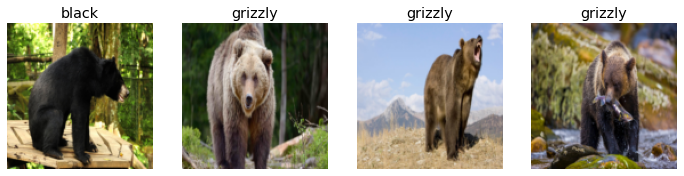

In [19]:
ursos = ursos.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = ursos.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Ainda é possível alterar as dimensões da imagem aplicando o pad, isto é, preenchendo as partes necessárias com pixels pretos. 

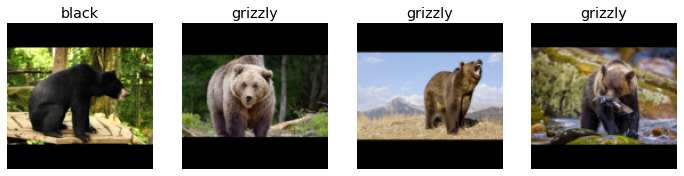

In [20]:
ursos = ursos.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode="zeros"))
dls = ursos.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Porém, todos os métodos citados possuem desvantagens. Por exemplo, ao realizar o crop, podemos deixar de extrair características importantes da imagem. Ao realizar o squish, treinamos o modelo com imagens deformadas, possivelmente diferentes daqueles que serão apresentadas a ele. Ao realizar o pad, desperdiçamos processamento com partes insignificantes da imagem. 

Em vez de usar tais métodos, o que geralmente fazemos é selecionar aleatoriamente diferentes partes de uma imagem em cada época, realizando o crop apenas desta parte. Dessa forma, nosso modelo pode aprender a focar e reconhecer diferentes características de nossas imagens. Isso também reflete como as imagens se comportam na vida real, você pode ter fotos de um mesmo objeto tiradas de forma levemente diferente.

Para tanto, podemos empregar o método <code>RandomResizedCrop</code>, para o qual devemos especificar a dimensão do crop e a escala mínima que determina quanto da imagem será selecionado a cada vez. O efeito desse método pode ser visualizado abaixo para um exemplo do dataset de treino.

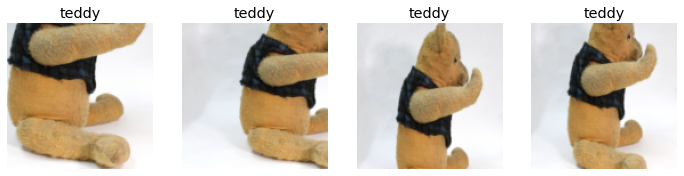

In [21]:
ursos = ursos.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = ursos.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## 3.3- Aumento dos dados 

<code>RandomResizedCrop</code> é um exemplo específico de técnica mais geral denominada aumento de dados (data augmentation), a qual visa realizar alterações nos dados de entrada a fim de torná-los ligeiramente diferentes, porém sem alterar seu sentido. No contexto de imagens, podemos ainda aplicar rotação, flipping, distorção de perspectiva, mudança no brilho, mudança no contraste, etc. 

O aumento de dados é importante, pois podemos diversificar os dados com os quais nosso modelo é treinado, o qual pode aprender, assim, a reconhecer diferentes características de nossas imagens. Nesse contexto, o fastai provê um conjunto de técnincas predefinidas de aumento dos dados por meio da função <code>aug_transforms</code>. Podemos ver o resultado dessa função em nosso dataset de treino por meio do código abaixo. 

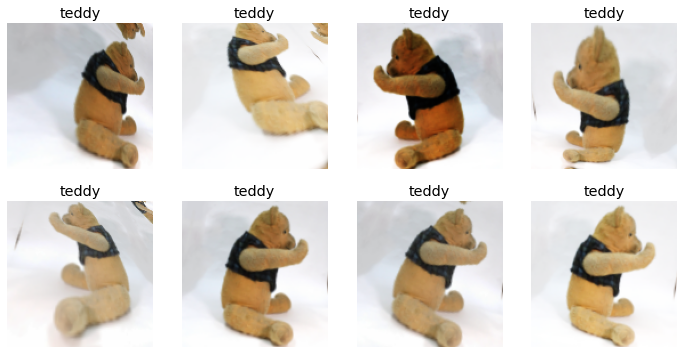

In [22]:
ursos = ursos.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = ursos.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

No exemplo acima, não estamos empregando ainda o <code>RandomResizedCrop</code>, além disso, estamos aplicando o dobro do aumento de dados do que o normal por meio do parâmetro <code>mult=2</code>. Dessa forma, vamos aplicar agora as transformação definitivas apropriadas em nosso dataset com base no que vimos. 

In [23]:
ursos = ursos.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                  batch_tfms=aug_transforms())
dls = ursos.dataloaders(path)

# 4- Treinamento

Pronto, já podemos treinar nosso modelo. Iremos empregar novamente uma rede neural convulocional já treinada, como no notebook passado, apenas alterarando a arquitetura para Resnet18, uma vez que estamos trabalhando com menos dados, no máximo 150 imagens por categoria. Dessa forma, aplicaremos a técnica de fine-tuning com 4 épocas, aprendida na introdução de transferência de aprendizagem.

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.351965,0.140592,0.035714,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.185713,0.064636,0.023810,00:06
1,0.149792,0.066740,0.011905,00:06
2,0.120155,0.065153,0.011905,00:06
3,0.100364,0.064445,0.011905,00:06


# 5- Analisando os erros 

Podemos verificar os erros do nosso modelo por meio de uma matriz de confusão, cujas linhas representam as categorias de fato dos dados, enquanto as colunas representam as categorias previstas. O ideal seria ter o máximo de números na diagonal, isto é, as categorias previstas são as categorias de fato dos dados. 

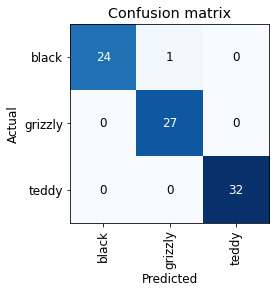

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Por exemplo, na matriz acima, nosso modelo previu que uma imagem do dataset de validação era a de um usro pardo, enquanto que, na verdade, ela pertencia à categoria de ursos pretos. 

É interessante visualizar se nossos erros ocorrem devido a um problema no dataset ou no modelo. Para tanto, podemos ordendar nosssas imagens com base no loss, um número que é maior se o modelo estiver incorreto, especialmente se estiver confiante de sua resposta incorreta, ou se estiver correto, porém inseguro de sua resposta correta. 

Nesse contexto, podemos utilizar o método <code>plot_top_losses</code>, o qual ordena as imagens de acordo com o critério de loss, informando também a categoria prevista, a categoria de fato, o valor do loss e a probabilidade. 

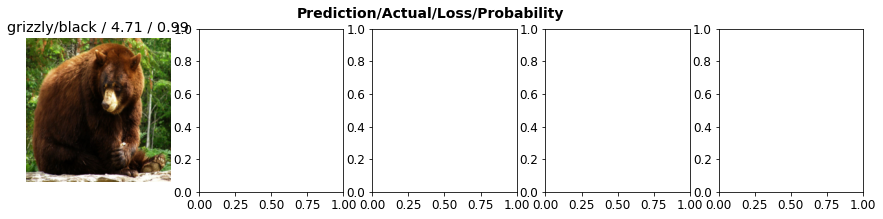

In [26]:
interp.plot_top_losses(5, nrows=1)

Assim, podemos observar a imagem classificada erroneamente. No entanto, note que apesar de ter sido rotulada como urso preto e de não sermos especialistas em ursos, o urso apresentado na imagem parece muito mais um urso pardo do que um urso preto.  

Dessa forma, constatamos que o problema está em nosso dataset, ou seja, rotulamos erroneamente uma imagem. Nesse contexto, precisaríamos transferir essa imagem para a pasta grizzly bear. Essa é a etapa de limpeza dos dados, a qual geralmente ocorre antes do treinamento, mas pode ser realizada posteriormente com base na intuição de onde estão nososs erros proveniente dos resultados do treinamento.

# 6- Produção

Uma vez que nosso modelo estiver de acordo com nossas expectativas, podemos levá-lo à produção, por exemplo, ao salvá-lo em um servidor a fim de realizar inferências remotamente. Sim, chamamos nossas predições de inferências quando já estamos em produção. Para tanto, precisamos exportar nosso modelo. 

## 6.1 - Exportanto e importando o modelo

Exportar nosso modelo é simples, precisamos apenas utilizar o método <code>export</code>. Então, salvaremos nosso modelo como mod_class_ursos.pkl

In [27]:
learn.export('mod_class_ursos.pkl')

Podemos verificar se o modelo realmente foi salvo pelo código abaixo. 

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('mod_class_ursos.pkl')]

Importar nosso modelo também é simples, basta utilizar a função <code>load_learner</code>, passando como parâmetro o caminho do modelo salvo.

In [29]:
learn_inf = load_learner(path/'mod_class_ursos.pkl')

O interessante é que além do modelo, as informações de como criar os <code>dataloader</code>s também são salvas. Assim, não precisamos nos preocupar em tratar manualmente a imagem, redimensionando, por exemplo, seu tamanho. Ainda se lembra da primeira imagem que baixamos como teste?


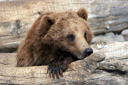

In [30]:
imagem_teste = 'imagens/grizzly.jpg'

imagem = Image.open(destino)
imagem.to_thumb(128,128)

Bem, iremos fazer uma inferência como teste a fim de verificar se importamos corretamente nosso modelo. Para tanto, basta empregar o método <code>predict</code>, passando a localização da imagem a ser inferida. 

In [31]:
learn_inf.predict(imagem_teste)

('grizzly', TensorBase(1), TensorBase([7.6312e-05, 9.9990e-01, 2.7680e-05]))

Perceba qua o método retorna uma tupla, na qual o primeira item se refere a categoria prevista, no caso, a um urso pardo como esperado. 

Já o segundo item se refere ao índice da categoria na lista de categorias armazenadas, a qual pode ser aceassada pelo código abaixo. 

In [32]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

O terceiro item se refere às probabilidades ordenadas de acordo com as categorias. Podemos notar que o modelo infere a categoria de urso pardo com probabilidade de 0.9999 ou 99.99%. 

## 6.2- Criando um app a partir do notebook

Neste ponto, você pode considerar nosso modelo como uma função qualquer da aplicação que está desenvolvendo. Assim, pode desenvolvê-la como achar melhor, empregando a framework que desejar, apenas integrando o modelo posteriormente. No entanto, abordarei aqui um método rápido para tornar o notebook que escrevemos uma aplicação web por meio do pacote voilà, o qual aproveita os widgets IPython.

Widgets IPython são componentes de GUI que trazem consigo código em JavaScript e funcionalidades do Python, podendo ser criados no navegador por meio no notebook Jupyter. Dessa forma, o voilà aproveita os widgets IPython para fazer as aplicações sem que o usuário final tenha instalado o Jupyter notebook. 

Dessa forma, vamos ver alguns exemplos de widgets que podemos instanciar. Por exemplo, se lembra do botão de upload do notebook passado? Ele é um widget IPython.

In [33]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

Caso carreguemos uma imagem por meio do botão, por exemplo, a imagem utilizada acima para testar a inferência do modelo, podemos referenciá-la em nosso notebook por meio do código abaixo.

In [34]:
img = PILImage.create(btn_upload.data[-1])

A fim de exibí-la por meio de um widget IPython, precisamos apenas empregar o código a seguir.

In [35]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

A partir disso, podemos fazer nossa inferência. Para exibir o resultado, podemos empregar o widget referente a labels.

In [36]:
pred,pred_idx,probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Predição: {pred}; Probabilidade: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Predição: grizzly; Probabilidade: 0.9999')

Além disso, seria interessante termos um botão para realizer a classificação.

In [37]:
btn_run = widgets.Button(description='Classificar')
btn_run

Button(description='Classificar', style=ButtonStyle())

Para este botão, precisaremos também de um handler de evento quando ele for clicado. 

In [38]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

Por fim, só é necessário ordenar todos os componentes em uma caixa vertical.

In [39]:
VBox([widgets.Label('Selecione o seu urso!'),
btn_upload, btn_run, out_pl, lbl_pred])

Para criarmos o app definitivo, escreveremos o código acima em outro notebook que constará no mesmo diretório deste, intitulado 02-App.ipynb

Por fim, só precisamos instalar o voilà, caso não tenha, e pedir para ele rodas a aplicação. 

In [ ]:
#Instalar o voilà
!pip install voila

#Executar a aplicação 
!voila 02-App.ipynb